# Deep learning Morpion Solitaire

In [1]:
from MorpionSolitaire import *
from tqdm.notebook import trange
import ipywidgets as widgets
#from pathlib import Path

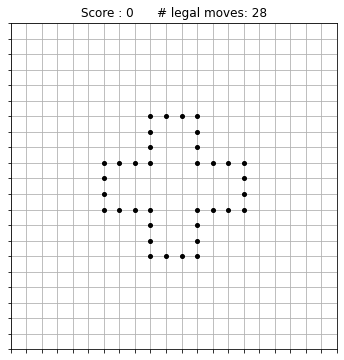

In [3]:
base = StartingGame()
base.print()

This function simply picks at random one of the allowed moves at any stage of the game

In [2]:
def pickatrandom(game): return np.random.randint(len(game.moves))

## Generate initial data

The algorithm that we are going to use is the following:
1. Play a game at random until the end
2. Rewind at random to an arbitrary intermediate step that we will call `exploration_game`
3. From this intermediate step, explore at random the possible completions, and keep the best score
4. Associate to the image of `exploration_game` the maximal score and save the image file.
The file name takes the following format: `id#####s###.png`, where the first 5-digit number is a unique identifier and the second 3-digit number the label, i.e. the number of expected moves remaing

Finally, repeat this loop as often as necessary to generate enough data.

The two parameters that control this data are:
- `n_games`: total number of games to be played (i.e. how many images are generated)
- `n_completions`: for each game, how many random completions do we perform


In [18]:
n_games = 1000
n_completions = 20
path = 'random_data/'

In [19]:
xdata = []
ydata = []
for i in trange(n_games):
    # 1. play at random
    random_game = base.play(pickatrandom)
    # 2. rewind
    exploration_game = random_game.get_parent(np.random.randint(random_game.score))
    # 3. explore completions
    best_score = random_game.score
    for _ in range(1,n_completions):
        random_game = exploration_game.play(pickatrandom)
        if random_game.score > best_score:
            best_score = random_game.score
    # 4. explore completions
    expectation = best_score - exploration_game.score
    xdata.append(exploration_game.score)
    ydata.append(expectation)
    im = exploration_game.grid.image()
    label = '{}id{:05}s{:03}.png'.format(path, i, expectation)
    im.save(label)

Frequency of scores in the data:

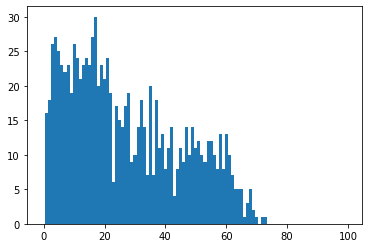

In [21]:
plt.hist(xdata, bins=100, range=(-0.5,99.5))
plt.show()

Comparison with the baseline model:

In [22]:
expdata = np.load('rand_expectation.npy')

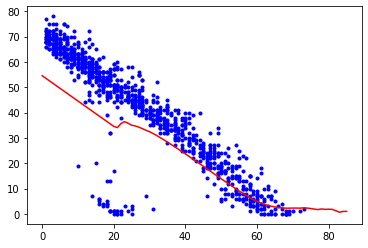

In [24]:
plt.scatter(xdata, ydata, color = 'b', marker = '.')
plt.plot(expdata, color = 'r')
plt.show()

In [45]:
def expectation(n):
    if n < len(expdata):
        return expdata[n]
    return 0

## Deep learning: first round